In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import pyro.distributions as dist
from pyro.infer import MCMC, HMC, NUTS, Predictive
import pyro
import torch
from torch.distributions import constraints
from torch.nn import Parameter

from src.data.preprocessing import detrend, ffnn_input_vector
from src.models.paths import PROJECT_ROOT
from src.models.solid_earth_utils import greens_function, FFNN
from src.data.data_loader import load_uplift
from src.models.paths import PROJECT_ROOT
from src.models.pyro_custom import IntervalFoldedDistribution

from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
import pyro.contrib.gp as gp
from pyro.nn.module import PyroParam, pyro_method

print(PROJECT_ROOT)
pyro.set_rng_seed(42)
%load_ext autoreload
%autoreload 2

/data/eigil/work/premis


In [2]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)


def plot(Xtest,
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
    limits=[0, 5],
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2, label="GP surface height model")  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test).double(), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(limits[0], limits[1])

In [3]:
def compute_error(trues, predicted):
    '''
    From course material
    '''
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    return corr, mae, rae, rmse

In [4]:
Nr = np.arange(1, 7).tolist()
radius = [6371e3, 6341e3, 6311e3, 5951e3, 5701e3, 3480e3]
density = [3.037e3, 3.230e3, 3.438e3, 3.871e3, 4.978e3, 10.750e3]
rigidity = [0.50605e11, 0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11, 0.0000e11]
bulk = [5.7437e10, 5.7437e10, 9.9633e10, 1.5352e11, 3.2210e11, 1.1018e12]
viscosity = [1.0e55, 1.0e21, 1.0e21, 1.0e21, 2.0e21, 0.0e21]

df_em = pd.DataFrame(
    np.array([Nr, radius, density, rigidity, bulk, viscosity]).T,
    columns=["Nr", "radius", "density", "rigidity", "bulk", "viscosity"],
)

lmax = 256
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

df = load_uplift()
height = df.Thickness.values
uplift = df.Up_kuaq.values

df_em

/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3230.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


(-100.0, 100.0)

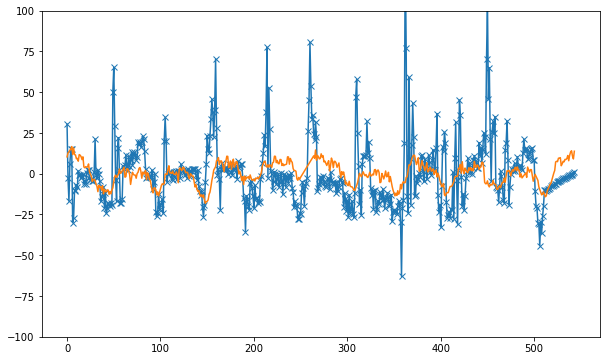

In [5]:
plt.figure(figsize=(10,6))
plt.plot(-0.1*detrend(height), linestyle=None, marker='x')
plt.plot(detrend(uplift))
plt.ylim([-100, 100])


In [36]:
y = -torch.tensor(detrend(height)).double()
X = torch.linspace(0, 1, len(y)).double()
# y = (y - y.mean())/y.std()

# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.Periodic(
    input_dim=1, variance=torch.tensor(30), lengthscale=torch.tensor(0.15), period=torch.tensor(0.1)
)
# gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.5))
Xu = torch.arange(100.0).double() / 100
gpr = gp.models.SparseGPRegression(X, y, kernel, Xu=Xu, noise=torch.tensor(20), jitter=1e-5)

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.8))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 0.5))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 3000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

corr = 0.49445689575916185, 
mae = 56.58490250668885, 
rae = 0.9593409269018881, 
rmse = 76.60822295912972
corr = 0.19396227140401964, 
mae = 133.99615624014422, 
rae = 0.9935813840487349, 
rmse = 195.93357092952957


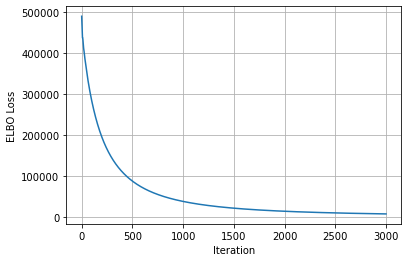

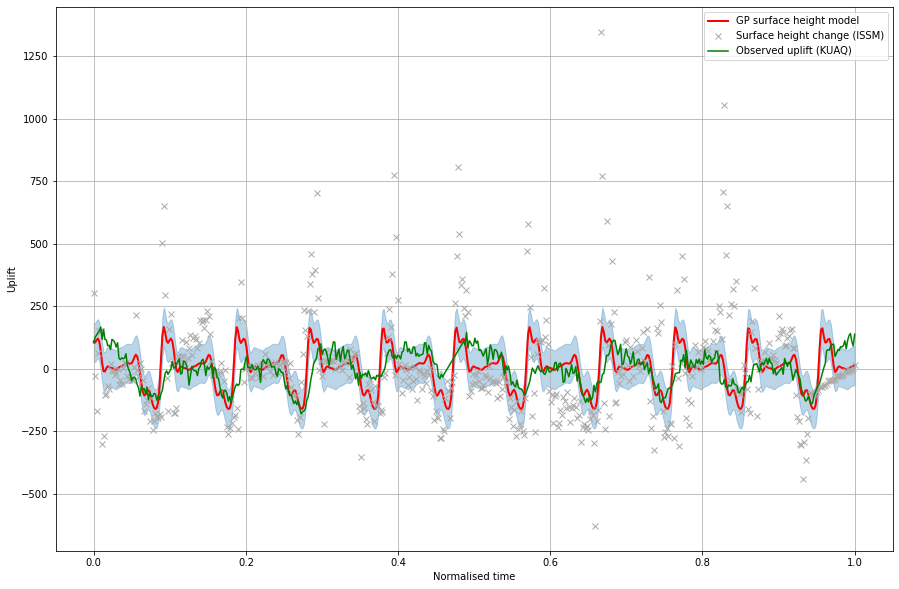

In [37]:

plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("ELBO Loss")
plt.grid()
plt.savefig("./GP_loss.png", dpi=400)

plt.figure(figsize=(15, 10))
ax = plt.gca()
upl = detrend(uplift)
X_test = torch.linspace(0, 1, len(uplift)).double()  # test inputs
# plot(X_test, model=gpr, plot_observed_data=True, plot_predictions=True, limits=[0, 1])
mean, cov = gpr(X_test, full_cov=True, noiseless=False)
sd = cov.diag().sqrt()  # standard deviation at each input point x

with torch.no_grad():
    ax.plot(X_test.numpy(), mean.numpy(), "r", lw=2, label="GP surface height model")  # plot the mean
    ax.fill_between(
        X_test.numpy(),  # plot the two-sigma uncertainty about the mean
        (mean - 2.0 * sd).numpy(),
        (mean + 2.0 * sd).numpy(),
        color="C0",
        alpha=0.3,
    )

plt.plot(X_test, y, linestyle="None", marker="x", label="Surface height change (ISSM)", color="darkgrey")
plt.plot(X_test, 10 * upl, label="Observed uplift (KUAQ)", color="green")
plt.xlabel("Normalised time")
plt.ylabel("Uplift")
plt.grid()
plt.legend()
plt.savefig("./GP_spregression.png", dpi=400)

preds = gpr(X_test, full_cov=True)[0].detach()
corr, mae, rae, rmse = compute_error(preds.numpy(), upl)
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")
corr, mae, rae, rmse = compute_error(y.numpy(), upl) # (upl - np.mean(upl)) / np.std(upl)
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")

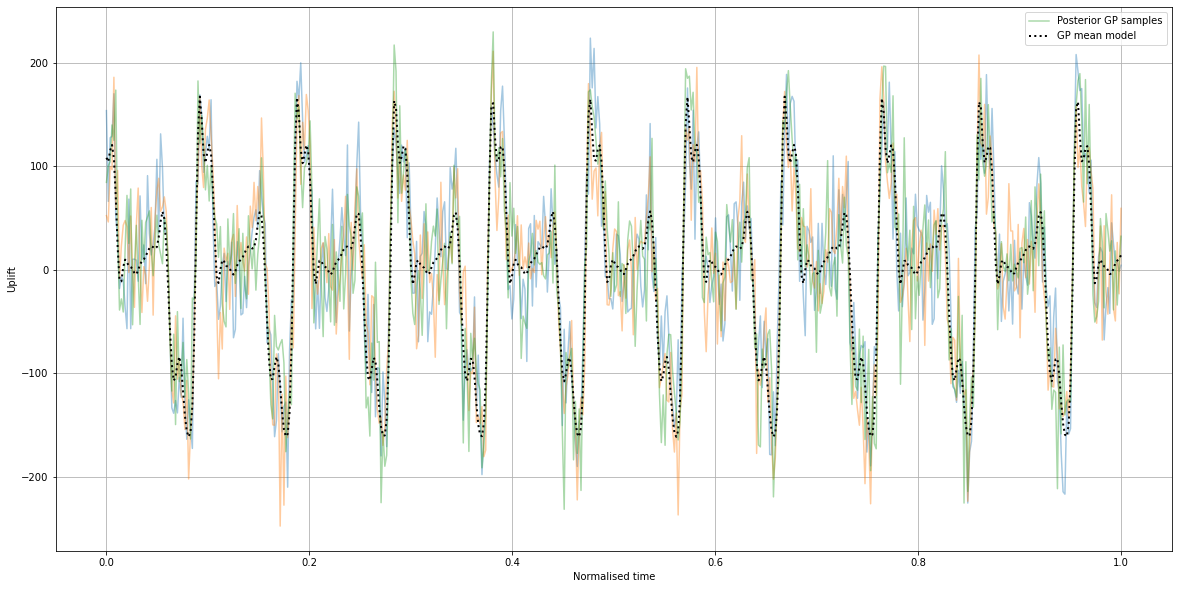

In [61]:
plt.figure(figsize=(20,10))
mean, cov = gpr(X_test, full_cov=True, noiseless=False)
for i in range(2):
    with torch.no_grad():
        sample = pyro.sample("test", dist.MultivariateNormal(mean, cov))
        plt.plot(X_test, sample, alpha=0.4)
        
sample = pyro.sample("test", dist.MultivariateNormal(mean, cov))
plt.plot(X_test, sample.detach(), alpha=0.4, label="Posterior GP samples")
plt.plot(X_test, mean.detach(), "black", lw=2, linestyle=":", label="GP mean model", alpha=1)
plt.xlabel("Normalised time")
plt.ylabel("Uplift")
plt.grid()
plt.legend()

In [196]:
gpr.model

AttributeError: 'function' object has no attribute 'posterior_samples'

/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at GPh
  warnings.warn(


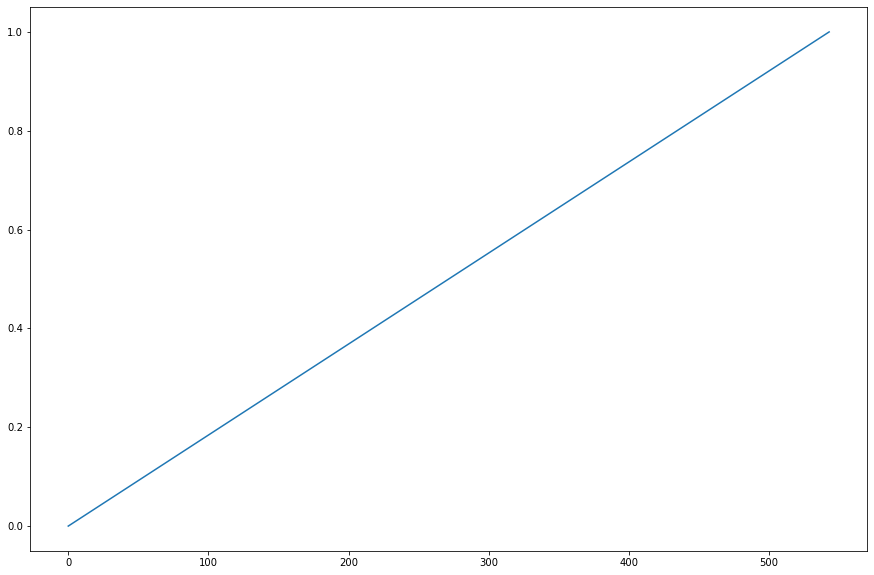

In [198]:
plt.figure(figsize=(15, 10))
samples = []
for i in range(100):
    samples.append(pyro.sample("GPh", dist.MultivariateNormal(torch.zeros(len(y)).double(), cov * 10)).detach().numpy())


samples = np.array(samples).mean(axis=0)
plt.plot(samples)
# plt.plot(range(len(y)), H.detach())

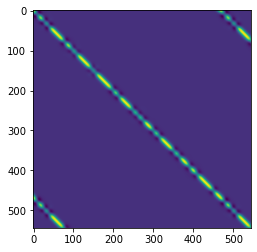

In [100]:
kernel = gp.kernels.Periodic(
    input_dim=1, variance=torch.tensor(1), lengthscale=torch.tensor(0.1)
)
# gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.1))
Xu = torch.arange(20.0).double() / 20
gpr = gp.models.SparseGPRegression(X, y, kernel, Xu=Xu, jitter=1e-5)

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.8))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.2))

H, cov = gpr(X_test, full_cov=True)

plt.imshow(cov.detach())

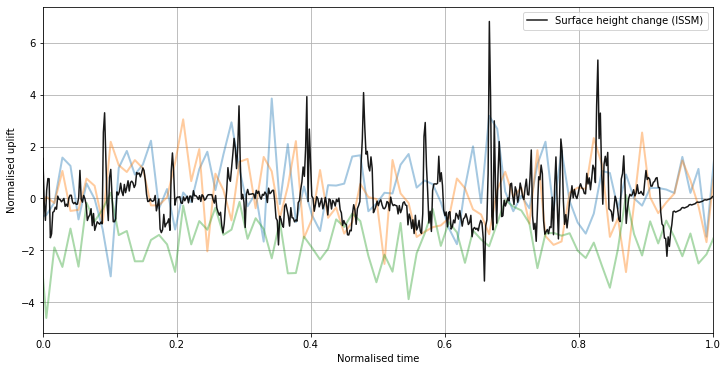

In [102]:
kernel = gp.kernels.Periodic(
    input_dim=1, variance=torch.tensor(1), lengthscale=torch.tensor(0.1), period=torch.tensor(0.1)
)
# gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.1))
Xu = torch.arange(20.0).double() / 20
gpr = gp.models.SparseGPRegression(X, y, kernel, Xu=Xu, jitter=1e-5)

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.8))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.2))

plot(X_test.double(), model=gpr, kernel=kernel, n_prior_samples=3, limits=[0, 1])
plt.plot(X_test, y, color="black", label="Surface height change (ISSM)", alpha=0.9)

plt.xlabel("Normalised time")
plt.ylabel("Normalised uplift")
plt.grid()
plt.legend()

### REPEAT WITH MCMC

$k(x,z) = \sigma^2\exp\left(-0.5 \times \frac{|x-z|^2}{l^2}\right).$

In [ ]:
# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.Exponential(
    input_dim=1, variance=torch.tensor(1), lengthscale=torch.tensor(0.1)
)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.1))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.9))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.2))

In [ ]:
nuts_kernel = NUTS(gpr.model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100)
mcmc.run()

Sample: 100%|██████████| 1100/1100 [00:27, 40.15it/s, step size=3.43e-01, acc. prob=0.882]


## TRY WITH MODEL

In [7]:
Nr = np.arange(1, 7).tolist()
radius = [6371e3, 6341e3, 6311e3, 5951e3, 5701e3, 3480e3]
density = [3.037e3, 3.230e3, 3.438e3, 3.871e3, 4.978e3, 10.750e3]
rigidity = [0.50605e11, 0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11, 0.0000e11]
bulk = [5.7437e10, 5.7437e10, 9.9633e10, 1.5352e11, 3.2210e11, 1.1018e12]
viscosity = [1.0e55, 1.0e21, 1.0e21, 1.0e21, 2.0e21, 0.0e21]

df_em = pd.DataFrame(
    np.array([Nr, radius, density, rigidity, bulk, viscosity]).T,
    columns=["Nr", "radius", "density", "rigidity", "bulk", "viscosity"],
)

lmax = 256
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

df = load_uplift()
height = df.Thickness.values
up_kuaq = df.Up_kuaq.values
up_mik2 = df.Up_mik2.values
df_em

/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3230.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [8]:
# For modelling seasonality at some point

# X_time = np.concatenate([pd.get_dummies(df[x]) for x in ["dow", "tod"]], axis=1)
# pd.get_dummies(df["Time"])
# Make month columns
df1 = pd.concat([df, df.Time.dt.month], axis=1)
df1.columns = [*df1.columns[:-1], 'Month']
df1.head()

# make one hot encoding of month number
month_number = np.array(pd.get_dummies(df1["Month"]))

In [9]:
standardized_height = (height - np.mean(height) / np.std(height))
X_cat = np.concatenate([standardized_height[np.newaxis].T, month_number], axis=1)
X_train = torch.tensor(X_cat).float()

In [10]:
y_train1 = torch.tensor(detrend(up_kuaq)).float()
y_train1 = (y_train1 - y_train1.mean()) / y_train1.std()

y_train2 = torch.tensor(detrend(up_mik2)).float()
y_train2 = (y_train2 - y_train2.mean()) / y_train2.std()

y_train = torch.vstack([y_train1, y_train2]).T
y_train.shape

torch.Size([544, 2])

In [11]:
df_params = pd.read_csv("../data/processed/ffnn_variable_normalisation_params.csv")
x = ffnn_input_vector(df_em)

In [12]:
ffnn = FFNN(31, 200, 258)  # in shape, n hidden, out shape
ffnn.load_state_dict(torch.load("../models/ffnn_v0.pt"))
ffnn.eval()

FFNN(
  (in_layer): Linear(in_features=31, out_features=200, bias=True)
  (h1_layer): Linear(in_features=200, out_features=200, bias=True)
  (h2_layer): Linear(in_features=200, out_features=200, bias=True)
  (out_layer): Linear(in_features=200, out_features=258, bias=True)
  (relu): ReLU()
)

In [13]:
N = 126
sigma_w = pyro.sample("sigma", dist.Normal(torch.zeros(12), torch.ones(12)))
X_train[:, 1:].matmul(sigma_w)

tensor([-0.6967, -0.6967, -0.6967, -0.6967, -0.0686, -0.0686, -0.0686, -0.0686,
        -0.2438, -0.2438, -0.2438, -0.2438, -0.0786, -0.0786, -0.0786, -0.0786,
        -0.0786, -0.1666, -0.1666, -0.1666, -0.1666,  0.3015,  0.3015,  0.3015,
         0.3015,  0.3015,  0.5413,  0.5413,  0.5413,  0.5413, -1.3299, -1.3299,
        -1.3299, -1.3299,  0.9839,  0.9839,  0.9839,  0.9839,  1.0781,  1.0781,
         1.0781,  1.0781,  1.0781, -0.8751, -0.8751, -0.8751, -0.8751, -0.2678,
        -0.2678, -0.2678, -0.2678, -0.6967, -0.6967, -0.6967, -0.6967, -0.6967,
        -0.0686, -0.0686, -0.0686, -0.0686, -0.2438, -0.2438, -0.2438, -0.2438,
        -0.2438, -0.0786, -0.0786, -0.0786, -0.0786, -0.1666, -0.1666, -0.1666,
        -0.1666,  0.3015,  0.3015,  0.3015,  0.3015,  0.3015,  0.5413,  0.5413,
         0.5413,  0.5413, -1.3299, -1.3299, -1.3299, -1.3299,  0.9839,  0.9839,
         0.9839,  0.9839,  1.0781,  1.0781,  1.0781,  1.0781,  1.0781, -0.8751,
        -0.8751, -0.8751, -0.8751, -0.26

In [135]:
def model(X, x, df_params, obs=None, df_em=None):
    # densities at index 7 and 8
    N = len(X)
    seasonality = 12 # months
    t = torch.linspace(0, 1, N).double()
    gp_y = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
    
    kernel = gp.kernels.Periodic(
        input_dim=1, variance=torch.tensor(1), lengthscale=torch.tensor(0.1)
    )
    # gpr = gp.models.GPRegression(t, X[:, 0], kernel, noise=torch.tensor(0.1))
    Xu = torch.arange(N).double() / 50
    gpr = gp.models.SparseGPRegression(t, gp_y.double(), kernel, Xu=Xu, jitter=5)

    # note that our priors have support on the positive reals
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.9))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.5))


    alpha_w = pyro.sample("alpha_v", dist.Normal(0., 1.))
    sigma_w = pyro.sample("sigma", dist.Normal(torch.zeros(seasonality, 2), torch.ones(seasonality, 2)))
    
    # rigidity layer 1
    loc, scale = 0, 1
    rigidity_1 = 1e10 + 1e10 * pyro.sample("rigidity_1", dist.Normal(loc, scale))

    # rigidity layer 2
    loc, scale = 0, 1
    rigidity_2 = 1e10 + 1e10 * pyro.sample("rigidity_2", dist.Normal(loc, scale))

    x[14] = (rigidity_1 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    x[15] = (rigidity_2 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    

    hlove = ffnn(x).detach().numpy()
    nlove = len(hlove)
    
    # Draw Greens Function
    gf_kuaq = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.58700000, -33.05270000],
        arsurf=80e3 * 80e3,
    )
    gf_mik2 = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.14029705, -31.45179999],
        arsurf=80e3 * 80e3,
    )
    gf = pyro.deterministic("gf", torch.tensor([gf_kuaq, gf_mik2]))

    # Fit height series with GP
    with pyro.plate("height", N):
        # set training data
        gpr.set_data(t, gp_y.double())

        # output the GP prediction
        H, _ = gpr(t, full_cov=True, noiseless=False)
    
    H = (H * X[:, 0].std()) + X[:, 0].mean()  
    # Draw target
    with pyro.plate("data", 2):
        w = pyro.sample("w", dist.Normal(- gf * H[..., None], torch.exp(alpha_w + X[:, 1:].matmul(sigma_w))))
    
    return w

In [136]:
# import os
# os.environ["OMP_NUM_THREADS"] = '1'
# Run inference in Pyro

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc.run(X_train, x, df_params, y_train, df_em)

Warmup:   0%|          | 0/1100 [1:14:53, ?it/s]


KeyboardInterrupt: 

In [141]:
def model(X, x, df_params, obs=None, df_em=None):
    # densities at index 7 and 8
    N = len(X)
    seasonality = 12 # months
    t = torch.linspace(0, 1, N).double()
    gp_y = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
    
    kernel = gp.kernels.Periodic(
        input_dim=1, variance=torch.tensor(1), lengthscale=torch.tensor(0.1)
    )
    # gpr = gp.models.GPRegression(t, X[:, 0], kernel, noise=torch.tensor(0.1))
    Xu = torch.arange(N).double() / 50
    gpr = gp.models.SparseGPRegression(t, gp_y.double(), kernel, Xu=Xu, jitter=1e-5)

    # note that our priors have support on the positive reals
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.9))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.5))

    # Fit height series with GP
    with pyro.plate("height", N):
        # set training data
        gpr.set_data(t, gp_y.double())

        # output the GP prediction
        H, _ = gpr(t, full_cov=True, noiseless=False)
    return H

In [142]:
# import os
# os.environ["OMP_NUM_THREADS"] = '1'
# Run inference in Pyro

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc.run(X_train, x, df_params, y_train, df_em)

Warmup:   0%|          | 0/1100 [00:00, ?it/s]

_LinAlgError: torch.linalg_cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 1 is not positive-definite).
          Trace Shapes:       
           Param Sites:       
                     Xu     20
          kernel.period       
 kernel.lengthscale_map       
    kernel.variance_map       
          Sample Sites:       
            height dist      |
                  value 544  |
kernel.lengthscale dist 544  |
                  value 544  |
   kernel.variance dist 544  |
                  value 544  |

In [ ]:
#  define model
def gp_ssm(data=None, N=1, T=2, d=1):
    X = dist.Uniform(0.0, 5.0).sample(sample_shape=(T,))
    y = 0.5 * torch.sin(3 * X) + dist.Normal(0.0, 0.2).sample(sample_shape=(T,))
    Xu = torch.arange(20.) / 4.0

    # initialize the kernel and model
    pyro.clear_param_store()
    kernel = gp.kernels.RBF(input_dim=d)
    # we increase the jitter for better numerical stability
    # sgpr = gp.models.SparseGPRegression(X, y, kernel, Xu=Xu, noise=torch.tensor(0), jitter=1.0e-5)
    sgpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.))

    # the latent time series you want to infer
    # initialize a vector where you'll save the inferred values
    latent = torch.empty((T, N))
    latent_gp = torch.empty((T, N))

    # Plate out the same state space model for N different obs
    with pyro.plate('data_plate', N) as n:
        x0 = pyro.sample('x0', dist.Normal(0, 1))  # or whatever your IC might be
        latent[0, n] = x0
        latent_gp[0, n] = x0
        # Assume the transition noise is a white Gaussian

        # The markov part
        for t in pyro.markov(range(1, T)):
        # for t in range(1, T):
            if t == 1:
                # generation of f1:
                cov = torch.eye(1)
                latent_gp[t, n] = dist.Normal(torch.zeros(t), cov). \
                    sample(sample_shape=(1,))
                # generation of x1: 【Note: transition noise is a white Gaussian 】
                x_t = pyro.sample(
                    f"x_{t}",
                    dist.Normal(latent_gp[t, n] + 0, torch.eye(1))
                )
                y_t = pyro.sample(
                    f"y_{t}",
                    dist.Normal(x_t, .1),   # observation noise: N(x_t, 0.1)
                    obs=data[t - 1, n] if data is not None else None
                )
                latent[t, n] = x_t
            else:
                # generation of x2：
                latent_gp_input = latent[0:t - 1, n].reshape(-1,)
                latent_gp_temp = latent_gp[1:t, n].reshape(-1,)

                # set training data
                sgpr.set_data(latent_gp_input, latent_gp_temp)

                # output the GP prediction
                latent_gp[t, n], cov = sgpr(latent[t - 1, n], full_cov=True, noiseless=False)

                # update state 
                x_t = pyro.sample(
                    f"x_{t}",
                    dist.MultivariateNormal(latent_gp[t, n] + 0, torch.eye(1))
                )
                y_t = pyro.sample(
                    f"y_{t}",
                    dist.Normal(x_t, .1),   # observation noise: N(x_t, 0.1)
                    obs=data[t - 1, n] if data is not None else None
                )
                latent[t, n] = x_t

    return pyro.deterministic('latent', latent)